In [1]:
%pip install python-dotenv
%pip install roboflow
%pip install supervision

In [2]:
# loads dataset
from roboflow import Roboflow
from dotenv import load_dotenv
import os

load_dotenv()  # loads variables from .env into the environment

api_key = os.getenv("YF_API_KEY")

rf = Roboflow(api_key=api_key)
project = rf.workspace("caretech").project("food-dataset-uj20h-w2s4m")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Food-Dataset-1 in yolov8:: 100%|██████████| 9832/9832 [00:06<00:00, 1541.65it/s]


In [3]:
# script to split training dataset
import os
import shutil
from pathlib import Path
import supervision as sv


# creates a new folder with just the images and labels
dir = Path('/content/Food-Dataset-1')
unified_dir = Path('/content/all')
split_path = Path('/content/split')

new_img_dir = unified_dir / 'images'
new_label_dir = unified_dir / 'labels'

new_img_dir.mkdir(parents=True, exist_ok=True)
new_label_dir.mkdir(parents=True, exist_ok=True)

# write to a flattened folder
for file in dir.rglob('*.jpg'):
    shutil.copy(file, new_img_dir)

exclude = ['README.roboflow.txt', 'README.dataset.txt']
for file in dir.rglob('*.txt'):
    if str(file.name) in exclude:
        continue
    shutil.copy(file, new_label_dir)


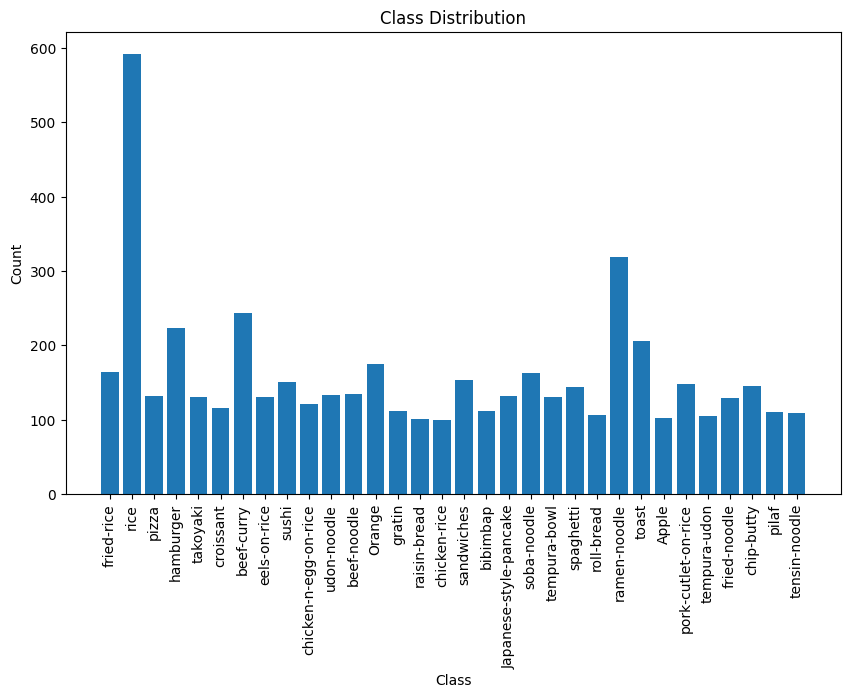

<Figure size 1000x600 with 0 Axes>

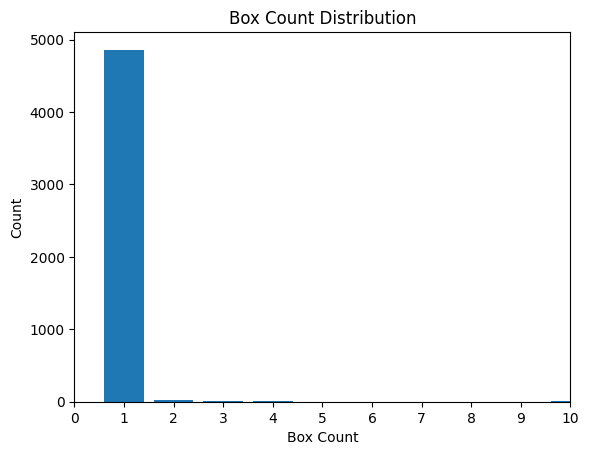

In [28]:
# class distribution count
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

class_labels = { i: ds.classes[i] for i in range(len(ds.classes)) }

class_count = defaultdict(int)
box_count = defaultdict(int)
for file in unified_dir.rglob('*.txt'):
    count = 0
    with open(file, 'r') as f:
        for line in f:
          arr = line.split()
          if not arr:
            continue

          i = int(arr[0])
          class_count[class_labels[i]] += 1
          count += 1

    box_count[count] += 1




# class distribution count
# image size
# aspect ratio
# boxes per image
# noise / blur

# plot
plt.figure(figsize=(10, 6))
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

# plot
plt.figure(figsize=(10, 6))
ax = plt.figure().gca()
plt.bar(box_count.keys(), box_count.values())
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 10])
plt.xlabel('Box Count')
plt.ylabel('Count')
plt.title('Box Count Distribution')
plt.show()

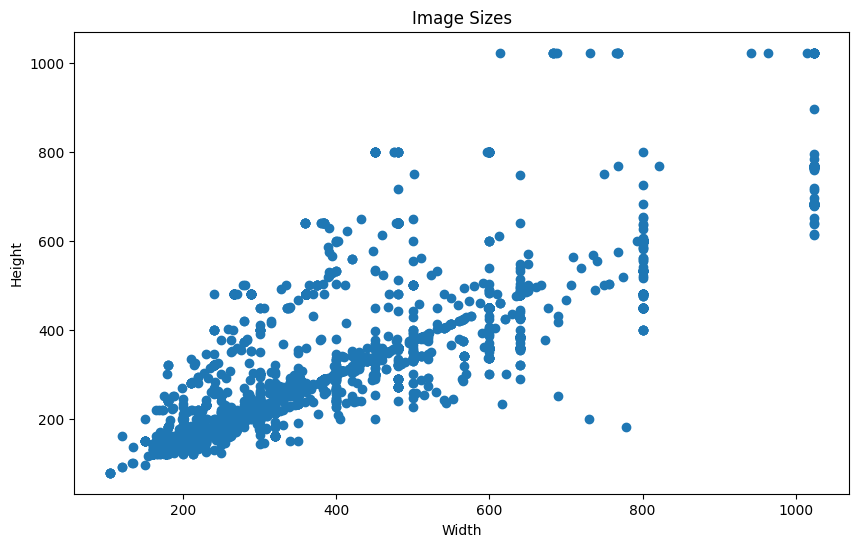

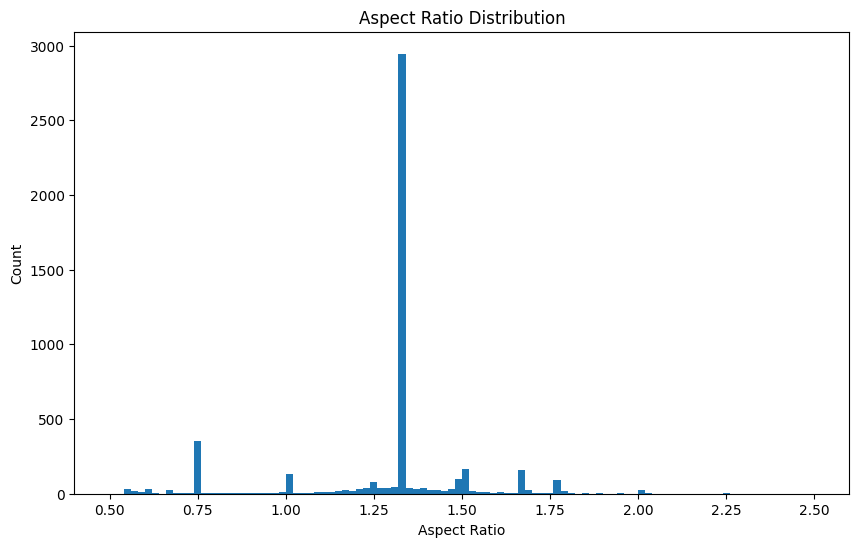

In [15]:
from PIL import Image

# image size
sizes: list[tuple[int, int]] = [] # width x height
for img in unified_dir.rglob('*.jpg'):
  with Image.open(img) as im:
    sizes.append(im.size)

ratios = [s[0] / s[1] for s in sizes]

# plot
plt.figure(figsize=(10, 6))
plt.scatter([s[0] for s in sizes], [s[1] for s in sizes])
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Sizes')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(ratios, bins=100, range=(0.5, 2.5))
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.title('Aspect Ratio Distribution')
plt.show()

In [4]:
# this loads a DetectionDataset object
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{str(new_img_dir)}",
    annotations_directory_path=f"{str(new_label_dir.name)}",
    data_yaml_path=f"{str(dir.name)}/data.yaml"
)

print(ds.classes)

seed = 1
# we can split this dataset deterministically
train_ds, rest_ds = ds.split(split_ratio=0.8, random_state=seed, shuffle=True)
test_ds, val_ds = rest_ds.split(split_ratio=0.5, random_state=seed, shuffle=True)

# save new datasets in yolo format
train_ds.as_yolo(
    images_directory_path=str(split_path / 'train' / 'images'),
    annotations_directory_path=str(split_path / 'train' / 'labels'),
    data_yaml_path=str(split_path / 'train' / 'data.yaml')
)
test_ds.as_yolo(
    images_directory_path=str(split_path / 'test' / 'images'),
    annotations_directory_path=str(split_path / 'test' / 'labels'),
    data_yaml_path=str(split_path / 'test' / 'data.yaml')
)
val_ds.as_yolo(
    images_directory_path=str(split_path / 'valid' / 'images'),
    annotations_directory_path=str(split_path / 'valid' / 'labels'),
    data_yaml_path=str(split_path / 'valid' / 'data.yaml')
)

# write the manifest files
def write_manifest(ds: sv.DetectionDataset, split: str, output_path: Path):
  with open(output_path, "w") as f:
    for img_path, _, _ in ds:
      f.write(f"{str(Path(img_path).name)}\n")

  print(f"Wrote to {output_path}")

write_manifest(train_ds, "train", Path(split_path) / "train.txt")
write_manifest(test_ds, "test", Path(split_path) / "test.txt")
write_manifest(val_ds, "valid", Path(split_path) / "valid.txt")

['Apple', 'Japanese-style-pancake', 'Orange', 'beef-curry', 'beef-noodle', 'bibimbap', 'chicken-n-egg-on-rice', 'chicken-rice', 'chip-butty', 'croissant', 'eels-on-rice', 'fried-noodle', 'fried-rice', 'gratin', 'hamburger', 'pilaf', 'pizza', 'pork-cutlet-on-rice', 'raisin-bread', 'ramen-noodle', 'rice', 'roll-bread', 'sandwiches', 'soba-noodle', 'spaghetti', 'sushi', 'takoyaki', 'tempura-bowl', 'tempura-udon', 'tensin-noodle', 'toast', 'udon-noodle']
Wrote to /content/split/train.txt
Wrote to /content/split/test.txt
Wrote to /content/split/valid.txt
